In [106]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils.hypothesis_functions import *
from utils.clean_functions import *


## INFORMACIÓN DEL PROYECTO

### TÍTULO

La guerra de Ucrania: precios, bajas y movimiento de refugiados


### TEMA

Una comparativa de 6 datasets de tamaños variables sobre diversos aspectos de la guerra de Ucrania que tienen que ver con las pérdidas (sobre todo, las rusas, de las que hay más datos disponibles), los refugiados y los precios en los puestos locales. El nexo de la mayoría son las fechas. Las hipótesis son:

1) Se espera que los precios en Ucrania oscilen en función del número de refugiados que huyen del país y de la cercanía al frente de los puestos de venta. Asimismo, un peor rendimiento por parte del bando ruso debería animar a los proveedores a vender en el país y aumentar la oferta

(Más refugiados, mayor lejanía del frente o más pérdidas rusas = precios más bajos)

2) Con el paso del tiempo, aumentan las pérdidas materiales rusas y se reducen las pérdidas humanas. Ello puede ser indicativo de una creciente preocupación de la administración rusa por la opinión pública, con lo que, entre otras cosas, usa más drones o artillería y menos tropas terrestres para minimizar la cuenta de bajas

(Uso mayor de tropas mecanizadas = uso reducido de soldados rasos = más pérdidas materiales y menos muertos)

3) Los ejércitos ruso y ucraniano todavía se sirven de mucho material de la Unión Soviética, que, en comparación con el equipamiento moderno, tiende a ser capturado o destruido con mayor frecuencia

(Uso de material soviético = más destrucciones y más capturas)

### OBTENCIÓN DE LOS DATOS

Acumulativo de refugiados ucranianos por fecha y destino (fuente original: API sobre actualizaciones de la guerra de RapidAPI):
https://www.kaggle.com/datasets/anuragbantu/ukraine-invasion-refugee-data-2022

Precios en cada mercado de Ucrania por fecha, tipo y geolocalización (fuente original: Centre for Humanitarian Data de la Oficina de Naciones Unidas para la Coordinación de Asuntos Humanitarios):
https://data.humdata.org/dataset/wfp-food-prices-for-ukraine

Pérdidas rusas personales por fecha (fuente original: múltiples, ver en Kaggle; entre ellas, el Ejército y el Ministerio de Defensa del Ucrania):
https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war

Pérdidas rusas materiales, según categorías generales, por fecha (fuente original: es el mismo Kaggle que el anterior):
https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war

Pérdidas materiales rusas, incluyendo modelo y fabricante, sin fecha (fuente original: Oryxspioenkop, web alemana de análisis datos de defensa de código abierto e investigación sobre la guerra):
https://www.kaggle.com/datasets/piterfm/2022-ukraine-russia-war-equipment-losses-oryx

Pérdidas materiales ucranianas, incluyendo modelo y fabricante, sin fecha (fuente original: es el mismo Kaggle que el anterior):
https://www.kaggle.com/datasets/piterfm/2022-ukraine-russia-war-equipment-losses-oryx


## LIMPIEZA

### df_refugees (acumulado de refugiados ucranianos por fecha y destino)

- Importo el dataframe i veo que no tiene nulos

In [107]:
df_refugees = pd.read_csv(r'.\data\Refugees.csv')

df_refugees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    665 non-null    int64  
 1   id            665 non-null    object 
 2   country       665 non-null    object 
 3   date          665 non-null    object 
 4   individuals   665 non-null    int64  
 5   centroid_lon  665 non-null    float64
 6   centroid_lat  665 non-null    float64
 7   lat_max       665 non-null    float64
 8   lon_max       665 non-null    float64
 9   lan_min       665 non-null    float64
 10  lon_min       665 non-null    float64
 11  source        665 non-null    object 
dtypes: float64(6), int64(2), object(4)
memory usage: 62.5+ KB


- Creo una función que convierte la columna de fechas ("date") en un datetime ordenado (index_by_datetime) y lo lleva al índice, lo cual me será útil si tengo que unificar tablas
- Dejo solo las columnas de país ("country") y acumulado de refugiados ("individuals")


In [108]:
index_by_datetime(df_refugees)

df_refugees = df_refugees[['country','individuals']]


- Compruebo que hay varios países que aparecen bastante menos que los demás. Sin embargo, como todavía no he igualado esta tabla a la otra necesaria para la hipótesis (es decir, la de precios), no tengo claro qué meses voy a necesitar ni qué días de esos meses serán el mejor punto de referencia (por aparecer en la otra tabla). Por tanto, de momento, los dejo todos

In [109]:
df_refugees['country'].value_counts()


Hungary                     106
Slovakia                    105
Poland                      102
Republic of Moldova         102
Romania                      93
Belarus                      76
Russian Federation           70
Other European countries     11
Name: country, dtype: int64

- Resultado:

In [110]:
df_refugees.head()


,country,individuals
date,,
2022-03-01,Belarus,341
2022-03-01,Poland,453982
2022-03-01,Hungary,116348
2022-03-01,Republic of Moldova,79315
2022-03-01,Russian Federation,42900


### df_prices (precios en cada mercado de Ucrania por fecha, tipo y longitud Este)

- Importo el dataframe y veo que hay algunos nulos

In [111]:
df_prices = pd.read_csv(r'.\data\Prices.csv', low_memory=False)

df_prices.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70731 entries, 0 to 70730
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       70731 non-null  object
 1   admin1     69685 non-null  object
 2   admin2     69685 non-null  object
 3   market     70731 non-null  object
 4   latitude   69685 non-null  object
 5   longitude  69685 non-null  object
 6   category   70731 non-null  object
 7   commodity  70731 non-null  object
 8   unit       70731 non-null  object
 9   priceflag  70731 non-null  object
 10  pricetype  70731 non-null  object
 11  currency   70731 non-null  object
 12  price      70731 non-null  object
 13  usdprice   70731 non-null  object
dtypes: object(14)
memory usage: 7.6+ MB


- Al mirar la cabecera de la tabla, y teniendo en cuenta que hay el mismo número de nulos en "admin1", "admin2", "latitude" y "longitude", salta a la vista que probablemente correspondan todos al valor de "market" llamado "National Average". Esa media no me interesa para el análisis

In [112]:
df_prices.head()


,date,admin1,admin2,market,latitude,longitude,category,commodity,unit,priceflag,pricetype,currency,price,usdprice
0,#date,#adm1+name,#adm2+name,#loc+market+name,#geo+lat,#geo+lon,#item+type,#item+name,#item+unit,#item+price+flag,#item+price+type,#currency,#value,#value+usd
1,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Bread (rye),Loaf,actual,Retail,UAH,4.96,0.135
2,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Bread (wheat),Loaf,actual,Retail,UAH,4.84,0.1318
3,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Buckwheat grits,KG,actual,Retail,UAH,7.44,0.2026
4,2014-03-15,NaN,NaN,National Average,NaN,NaN,cereals and tubers,Potatoes,KG,actual,Retail,UAH,6.74,0.1835


- Elimino el índice 0, puramente explicativo
- Elimino todas las filas donde el mercado sea, en realidad, la media nacional ("National Average")
- Cambio a numéricas las columnas "longitude" y "usdprice"
- Aplico la función que me pone la fecha en el índice (index_by_datetime)

In [113]:
df_prices = df_prices.drop(index=0)
df_prices = df_prices[df_prices['market'] != 'National Average']

df_prices[['usdprice', 'longitude']] = df_prices[['usdprice', 'longitude']].apply(pd.to_numeric, errors='coerce', axis=1)

index_by_datetime(df_prices)


- Limito el dataframe al período de la guerra con Russia

In [114]:
start_war = datetime.datetime(2022, 2, 24, 0, 0, 0)
df_prices = df_prices[df_prices.index >= start_war]


- Reduzco el dataframe a las columnas que me interesan para la hipótesis

In [115]:
df_prices = df_prices[['usdprice', 'market', 'commodity', 'longitude']]


Ahora debo elegir qué productos (en "commodity") me servirán para comparar las oscilaciones de precios en función de las bajas, los refugiados o la lejanía al frente. A ver qué opciones hay

In [116]:
df_prices.commodity.value_counts()


Wheat flour                          156
Rice                                 155
Buckwheat                            151
Sugar                                150
Antipyretic (local)                  150
Potatoes                             150
Fuel (petrol-gasoline, 92 octane)    149
Meat (beef)                          149
Vasodilating agents (imported)       148
Antipyretic (imported)               148
Millet                               148
Oil (sunflower)                      147
Carrots                              147
Onions                               147
Meat (chicken, fillet)               147
Fuel (diesel)                        146
Curd                                 145
Fat (salo)                           145
Fuel (petrol-gasoline, 95 octane)    145
Meat (pork)                          145
Semolina                             144
Pasta                                144
Cabbage                              144
Milk                                 144
Barley          

- Noto que los medicamentos vienen en 3 tipos (antibióticos, antipiréticos y agentes vasodilatadores), y que los tres pueden ser locales o importados, lo cual me ofrece dos dimensiones más para comparar. Además, como en la guerra suele haber más heridos que en períodos de paz, será más probable que se vean afectados en caso de encontrarse un mercado en zona de conflicto. Así pues, elijo conservar los medicamentos para mi tabla

In [117]:
df_prices = df_prices[(df_prices['commodity'].str.contains('imported')) |(df_prices['commodity'].str.contains('local'))]


- Resultado:

In [118]:
df_prices.head()


,usdprice,market,commodity,longitude
date,,,,
2022-03-15,4.8148,Rivne,Antibiotics (imported),26.251617
2022-03-15,1.0399,Rivne,Antibiotics (local),26.251617
2022-03-15,0.4625,Rivne,Antipyretic (local),26.251617
2022-03-15,0.3667,Rivne,Vasodilating agents (local),26.251617
2022-03-15,1.5907,Rivne,Vasodilating agents (imported),26.251617


### df_personnel (pérdidas rusas personales por fecha)

- Importo el dataframe y veo que hay algunos nulos

In [119]:
df_personnel = pd.read_csv(r'.\data\Russia_losses_personnel(date).csv')

df_personnel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        258 non-null    object 
 1   day         258 non-null    int64  
 2   personnel   258 non-null    int64  
 3   personnel*  258 non-null    object 
 4   POW         62 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 10.2+ KB


La columna de prisioneros de guerra ("POW") no me es útil para el análisis, y las de "personnel*" y "day", tampoco. Las elimino

In [120]:
df_personnel = df_personnel[['date', 'personnel']]


- Creo una función que me permite convertir columnas de valores acumulados en valores absolutos (decumulate_columns), y se la aplico a "personnel"
- Utilizo, una vez más, la función que pasa la fecha al índice en forma de datetime (index_by_datetime)
- Elimino la primera fecha porque, al haber salido de un acumulado, coge cosas de fechas que no constan en la tabla

In [121]:
decumulate_columns(df_personnel, excluded=['date'])
index_by_datetime(df_personnel)

df_personnel.drop(index='2022-02-25', inplace=True)


- Resultado:

In [122]:
df_personnel.head()


,personnel
date,
2022-02-26,1500
2022-02-27,200
2022-02-28,800
2022-03-01,410
2022-03-02,130


### df_equipment (pérdidas rusas materiales, según categorías generales, por fecha)

- Importo el dataframe y veo que hay nulos en demasía

In [123]:
df_equipment = pd.read_csv(r'.\data\Russia_losses_equipment(date).csv')

df_equipment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       258 non-null    object 
 1   day                        258 non-null    int64  
 2   aircraft                   258 non-null    int64  
 3   helicopter                 258 non-null    int64  
 4   tank                       258 non-null    int64  
 5   APC                        258 non-null    int64  
 6   field artillery            258 non-null    int64  
 7   MRL                        258 non-null    int64  
 8   military auto              65 non-null     float64
 9   fuel tank                  65 non-null     float64
 10  drone                      258 non-null    int64  
 11  naval ship                 258 non-null    int64  
 12  anti-aircraft warfare      258 non-null    int64  
 13  special equipment          239 non-null    float64

Vamos a ver como se distribuyen los nulos en porcentaje

In [124]:
((df_equipment.isnull().sum() / len(df_equipment))*100).sort_values(ascending = False)


mobile SRBM system           86.046512
fuel tank                    74.806202
military auto                74.806202
greatest losses direction    29.457364
vehicles and fuel tanks      25.193798
cruise missiles              25.193798
special equipment             7.364341
field artillery               0.000000
MRL                           0.000000
APC                           0.000000
day                           0.000000
drone                         0.000000
naval ship                    0.000000
anti-aircraft warfare         0.000000
tank                          0.000000
helicopter                    0.000000
aircraft                      0.000000
date                          0.000000
dtype: float64

Una pequeña investigación me permite clasificar qué hay exactamente en las columnas de nulos. A parte de las "greatest losses direction" y "day", que no las necesito porque no son sobre equipamiento, veo que:
- Las columnas "military auto", "fuel tank" y "mobile SRBM system" están demasiado incompletas como para que tenga sentido usarlas, así que no hace falta darles más vueltas. Se eliminan
- "Vehicles and fuel tanks" puede no considerarse material de guerra al uso (fuel tanks no son tanques como se entendería en este contexto, sino meros silos de combustible), así que la quito
- "Cruise missile" es misil guiado en español. Es razonable considerarlo un tipo de munición pesada más que una arma en sí. Además, será destruido tanto si tiene éxito en su cometido como si no. Su comportamiento anómalo solo servirá para desvirtuar la tabla incluso tras una interpolación de los valores que contiene. Borro la columna
- Solo queda "special equiment". Podríamos rellenar los nulos de esta columna con la media/mediana y salvarla, ya que no son tantos, pero es mejor deshacerse de ella. La razón es que ni el propio creador del dataset en kaggle tiene claro qué contiene (si bien intuye que se trata de cosas como radios o misiles: https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war/discussion/316981). Si la teoría del autor es correcta, y contiene misiles, es similar a la columna "Cruise missile" que hemos visto en el punto anterior, por lo que conviene darle el mismo trato

In [125]:
df_equipment.dropna(axis=1, inplace=True)
df_equipment.drop(columns=['day'], inplace=True)


- Desacumulo las columnas (decumulate_columns) y llevo la fecha al índice (index_by_datetime)
- Añado una columna con la suma de los equipamientos
- Elimino la primera fecha porque, al haber salido de un acumulado, coge cosas de fechas que no constan en la tabla

In [126]:
decumulate_columns(df_equipment, excluded=['date'])
index_by_datetime(df_equipment)

df_equipment['total losses'] = df_equipment[['aircraft', 
                                        'helicopter',
                                        'tank',
                                        'APC',
                                        'field artillery',
                                        'MRL',
                                        'drone',
                                        'naval ship',
                                        'anti-aircraft warfare'
                                        ]].sum(axis=1)

df_equipment.drop(index='2022-02-25', inplace=True)


- Resultado:

In [127]:
df_equipment.head()

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,total losses
date,,,,,,,,,,
2022-02-26,17,19,66,190,0,0,2,0,0,294
2022-02-27,0,0,4,0,1,0,0,0,0,5
2022-02-28,2,3,0,110,24,17,1,0,5,162
2022-03-01,0,0,48,30,3,3,0,0,2,86
2022-03-02,1,2,13,16,8,16,0,0,2,58


### df_tech (pérdidas materiales rusas, incluyendo modelo y fabricante, sin fecha)

- Importo el dataframe y veo que hay nulos en cantidades industriales

In [128]:
df_tech = pd.read_csv(r'.\data\Russia_losses_equipment(tech_details).csv')

df_tech.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 19 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   equipment                                    298 non-null    object 
 1   model                                        298 non-null    object 
 2   sub_model                                    8 non-null      object 
 3   manufacturer                                 298 non-null    object 
 4   losses_total                                 298 non-null    int64  
 5   abandoned                                    77 non-null     float64
 6   abandoned and destroyed                      17 non-null     float64
 7   captured                                     196 non-null    float64
 8   captured and destroyed                       7 non-null      float64
 9   captured and stripped                        4 non-null      float64
 10  da

Compruebo cuántos nulos hay en total

In [129]:
df_tech.isnull().sum().sum()


3740

- Son muchos. Ahora bien, ¿cuántos de esos nulos son, en realidad, ceros (porque ha habido 0 bajas de ese tipo para tal pieza de equipamiento)? La manera de saberlo es fijarse en la columna "losses_total"; el total de bajas para cada pieza debería ser una suma de las destruidas y las capturadas. Si se queda corto, es que faltan datos
- Empiezo por cambiar los NaN por 0
- Sumo los capturados y los pongo en una nueva columna, y hago lo propio con el resto de bajas
- Limito el dataframe a las columnas que he creado y a las especificaciones del equipamiento (excepto "sub_model", que es innecesaria para la hipótesis)

In [130]:
df_tech.fillna(0.0, inplace=True)

df_tech['total captured'] = df_tech[['captured', 
                                    'captured and destroyed',
                                    'captured and stripped',
                                    'damaged and captured'
                                    ]].sum(axis=1)

df_tech['total not captured'] = df_tech[['abandoned', 
                                        'abandoned and destroyed',
                                        'damaged',
                                        'damaged and abandoned',
                                        'damaged beyond economical repair',
                                        'damaged by Bayraktar TB2',
                                        'destroyed',
                                        'destroyed by Bayraktar TB2',
                                        'destroyed by Bayraktar TB2 and Harpoon AShM',
                                        'sunk'
                                        ]].sum(axis=1)

df_tech = df_tech[['equipment','model', 'manufacturer', 'losses_total', 'total captured', 'total not captured']]


- Hago la comprobación. Parece que el total de pérdidas coincide con la suma de las partes para cada pieza de equipo. Por ende, no faltan datos a pesar de que hay multitud de nulos

In [131]:
all(df_tech['losses_total']) == all(df_tech['total captured'] + df_tech['total not captured'])


True

- Resultado

In [132]:
df_tech.head()


,equipment,model,manufacturer,losses_total,total captured,total not captured
0,Tanks,T-62M,the Soviet Union,20,16.0,4.0
1,Tanks,T-62MV,the Soviet Union,3,2.0,1.0
2,Tanks,T-64A,the Soviet Union,2,0.0,2.0
3,Tanks,T-64BV,the Soviet Union,39,5.0,34.0
4,Tanks,T-72A,the Soviet Union,33,15.0,18.0


### df_uk_tech (pérdidas materiales ucranianas, incluyendo modelo y fabricante, sin fecha)

- Este dataframe es idéntico al anterior, pero con pérdidas ucranianas. Por tanto, el tratamiento es el mismo

In [133]:
df_uk_tech = pd.read_csv(r'.\data\Ukraine_losses_equipment(tech_details).csv')

df_uk_tech['total captured'] = df_uk_tech[['captured', 
                                            'captured and destroyed',
                                            'damaged and captured',
                                            'damaged by Orion and captured',
                                            'sunk but raised by Russia'
                                            ]].sum(axis=1)

df_uk_tech['total not captured'] = df_uk_tech[['abandoned', 
                                                'abandoned and destroyed',
                                                'damaged',
                                                'damaged and abandoned',
                                                'damaged beyond economical repair',
                                                'damaged by Forpost-R',
                                                'destroyed',
                                                'destroyed by Forpost-R',
                                                'destroyed by Orion',
                                                'destroyed by loitering munition',
                                                'scuttled to prevent capture by Russia',
                                                'sunk'
                                                ]].sum(axis=1)

df_uk_tech = df_uk_tech[['equipment','model', 'manufacturer', 'losses_total', 'total captured', 'total not captured']]


Por si las moscas, hago la comprobación

In [134]:
all(df_uk_tech['losses_total']) == all(df_uk_tech['total captured'] + df_uk_tech['total not captured'])


True

- Resultado

In [135]:
df_uk_tech.head()


,equipment,model,manufacturer,losses_total,total captured,total not captured
0,Tanks,T-64A,the Soviet Union,1,1.0,0.0
1,Tanks,T-64B,the Soviet Union,1,0.0,1.0
2,Tanks,T-64BV,the Soviet Union,123,53.0,70.0
3,Tanks,T-64BV Zr. 2017,Ukraine,49,27.0,22.0
4,Tanks,T-64B1M,Ukraine,4,4.0,0.0


## HIPÓTESIS

### Hipótesis 1

Se espera que los precios en Ucrania oscilen en función del número de refugiados que huyen del país y de la cercanía al frente de los puestos de venta. Asimismo, un peor rendimiento por parte del bando ruso debería animar a los proveedores a vender en el país y aumentar la oferta

(Más refugiados, mayor lejanía del frente o más pérdidas rusas = precios más bajos)

#### Hipótesis 1: parte A

(Mayor lejanía del frente = precios más bajos)

- Miro el dataframe "df_prices"

In [136]:
df_prices.head()


,usdprice,market,commodity,longitude
date,,,,
2022-03-15,4.8148,Rivne,Antibiotics (imported),26.251617
2022-03-15,1.0399,Rivne,Antibiotics (local),26.251617
2022-03-15,0.4625,Rivne,Antipyretic (local),26.251617
2022-03-15,0.3667,Rivne,Vasodilating agents (local),26.251617
2022-03-15,1.5907,Rivne,Vasodilating agents (imported),26.251617


- Separo el dataframe entre medicamentos locales o importados
- Creo una función ad hoc (create_lmplot_w_regression_line) que me dibuja un gráfico de tipo lmplot pero que, dado que voy a necesitar un par (el de importados y el de locales), y serán muy parecidos, que lo haga con algunos valores por defecto. Así me ahorro escribir lo mismo dos veces. No me la llevo a utils porque solo sirve para este caso

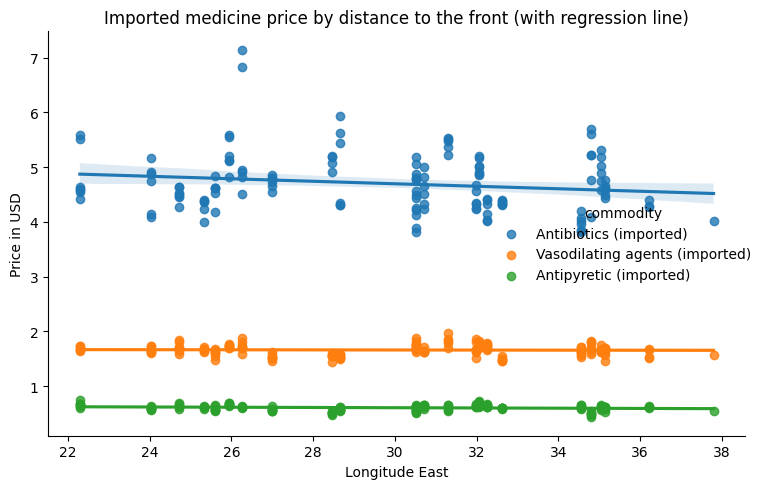

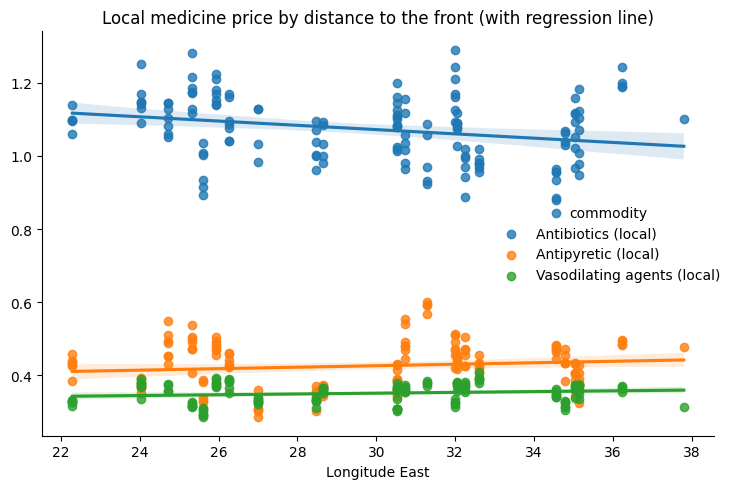

In [137]:
'''Creates a seaborn lmplot with regression lines using a few default values'''
def create_lmplot_w_regression_line(data, x="longitude", y="usdprice", hue=None, xlabel='Longitude East', ylabel=None, title=None):
    '''Requires a dataframe and two column names. Other parameters are optional and homonym to the ones used in a seaborn lmplot'''
    sns.lmplot(data=data, x=x, y=y, hue=hue)
    plt.ylabel(ylabel=ylabel)
    plt.xlabel(xlabel=xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()  


df_prices_imported = df_prices[df_prices['commodity'].str.contains('imported')]
df_prices_local = df_prices[df_prices['commodity'].str.contains('local')]

create_lmplot_w_regression_line(df_prices_imported, ylabel='Price in USD', hue="commodity", title='Imported medicine price by distance to the front (with regression line)')
create_lmplot_w_regression_line(df_prices_local, hue="commodity", title='Local medicine price by distance to the front (with regression line)')


- Si bien la línea de regresión de los antibióticos baja un poco al ir acercándose al frente, es un cambio demasiado pequeño como para considerarse significativo. Así las cosas, una mayor distancia al frente no reduce necesariamente el precio de las medicinas
- Se nota, también, que los precios de los importados son muy superiores
- El precio de los locales, a priori, oscila para los tres medicamentos, lo vemos por la distancia que hay entre los puntos y la recta de regresión, lo que hace pensar que no hay un suministro estable. Eso explicaría que se importen tantos como para que Naciones Unidas los haya clasificado en dos grupos
- Ocurre lo mismo con los antibióticos de importación. Como no necesito ya la distancia al frente, me basta con calcular la desviación típica de los precios para hacerme una idea de cuán superior es la dispersión de los antibióticos

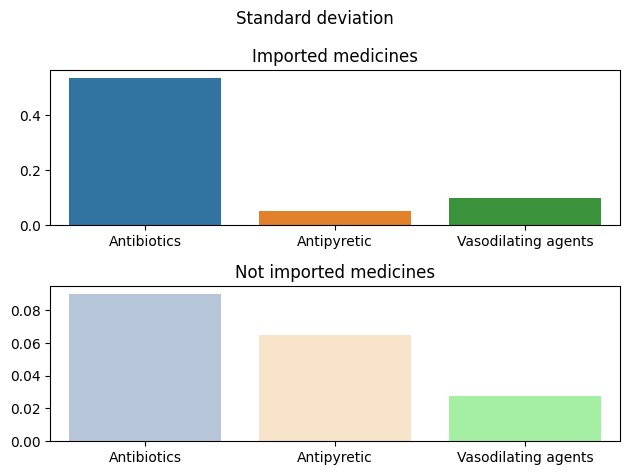

In [138]:
df_imp_antibiotics, df_imp_antipyretic, df_imp_vasodilating = [table for med, table in df_prices_imported.groupby('commodity')]
df_loc_antibiotics, df_loc_antipyretic, df_loc_vasodilating = [table for med, table in df_prices_local.groupby('commodity')]

plt.subplot(2, 1, 1)
sns.barplot(x=['Antibiotics','Antipyretic', 'Vasodilating agents'], y=[df_imp_antibiotics['usdprice'].std(), df_imp_antipyretic['usdprice'].std(), df_imp_vasodilating['usdprice'].std()])
plt.title('Imported medicines')
plt.subplot(2, 1, 2)
sns.barplot(x=['Antibiotics','Antipyretic', 'Vasodilating agents'], y=[df_loc_antibiotics['usdprice'].std(), df_loc_antipyretic['usdprice'].std(), df_loc_vasodilating['usdprice'].std()], 
                                                                        palette = ['lightsteelblue','bisque', 'palegreen']
            )
plt.title('Not imported medicines')
plt.suptitle('Standard deviation')
plt.tight_layout()
plt.show()


- La desviación típica es mayor en el caso de los antibióticos comparada con los otros dos, tanto para los locales como para los importados
- Lo que ocurre probablemente sea lo siguiente: cuando los agentes vasodilatadores, los antipiréticos y los antibióticos locales sufren escasez, los precios oscilan (la demanda es el principal factor que hace oscilar los precios de un mercado). Cuando eso pasa, la gente recurre más a los importados, de mayor precio. Como el suministro de agentes vasodilatadores y antipiréticos importados no llega a escasear, su desviación estándar es baja. En cambio, la alta oscilación de los antibióticos locales sigue presente con los importados. Es razonable suponer, pues, que el suministro de antibióticos importados es insuficiente para compensar la escasez de sus homónimos locales
- En cuanto al total de medicamentos, ¿qué tan grave es esa oscilación de precios? Para descubrirlo, creo una función que calcula el índice de Gini (calculate_gini). Normalmente el Gini se usa para comprobar si un reparto es equitativo; aquí me sirvo de él para ver si los costes de los medicamentos se reparten de forma justa entre los diferentes mercados. Necesito, para ello, la media (o la mediana) de precios de cada mercado

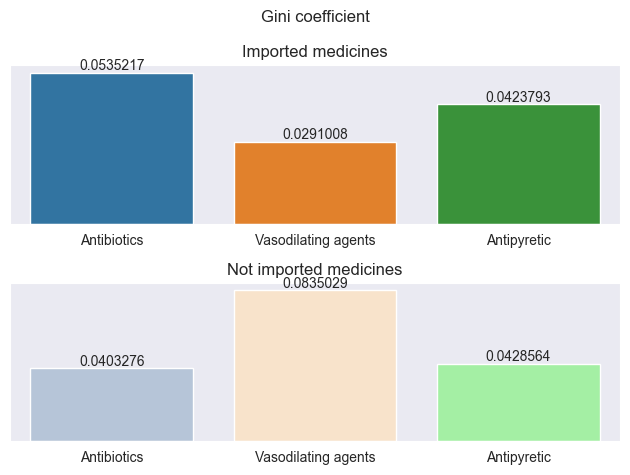

In [139]:
with sns.axes_style("dark"):
    fig, ax = plt.subplots(2)
    sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[calculate_gini(df_imp_antibiotics[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_imp_vasodilating[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_imp_antipyretic[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        ],
                                                                        ax=ax[0]
                )
    ax[0].set_title('Imported medicines')

    sns.barplot(x=['Antibiotics','Vasodilating agents','Antipyretic'], y=[calculate_gini(df_loc_antibiotics[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_loc_antipyretic[['usdprice','market']].groupby('market').mean(), 'usdprice')[0], 
                                                                        calculate_gini(df_loc_vasodilating[['usdprice','market']].groupby('market').mean(), 'usdprice')[0]
                                                                        ],
                                                                        ax=ax[1],
                                                                        palette = ['lightsteelblue','bisque', 'palegreen']
                )

    for number in range (0,2):
        for i in ax[number].containers:
            ax[number].set_yticks([])
            ax[number].bar_label(i,)

    ax[1].set_title('Not imported medicines')
    fig.suptitle('Gini coefficient')

    fig.tight_layout()
    plt.show()


- El resultado es tan concluyente (muy alejado de 1) que da igual, para el caso, investigar si es mejor servirse de la media o la mediana, así que lo dejo con la media
- El índice de Gini está cerca de 0 para todos los medicamentos, lo cual indica que un usuario de a pie no se dará cuenta con facilidad de que el precio varía de ciudad a ciudad
- Por ende, aunque la dispersión de los antibióticos pueda ser un síntoma de escasez, esos cambios en los precios no son tan grandes como para considerarse injustos. Por tanto, sin tener en cuenta el ya de por si elevado precio de los medicamentos importados, la preocupación debería ser la posibilidad de que falten antibióticos antes que el efecto de la dispersión de los precios en el bolsillo de los compradores ucranianos

#### Hipótesis 1: parte B

(Más pérdidas rusas = precios más bajos)

- Quiero comprobar, ahora, si los precios oscilan con las bajas rusas, personales y materiales. La cuestión es que los precios los tengo calculados mensualmente, mientras que las bajas, diariamente. Quiero saber, para cada mes que aparece en el índice de los precios (df_prices), cuantas bajas ha habido durante el mes previo en las tablas de bajas
- Por ejemplo, si en la tabla de precios tengo el mes 2022-05-15, quiero sumar las bajas desde 2022-05-14 hasta 2022-04-15... y así para cada mes de la tabla de precios (excepto el primero, ya que se trata de 2022-03-15, y no hay cuenta de bajas antes del 2022-02-25)
- Para ello, creo una función (date_index_to_monthly)

In [140]:
datetimes_to_study = df_prices.index.drop_duplicates()
df_monthly_personnel_datetime, df_monthly_personnel = date_index_to_monthly(df_personnel, 'personnel', 'Personnel losses', datetimes_to_study[1:])
df_monthly_equipment_datetime, df_monthly_equipment =  date_index_to_monthly(df_equipment, 'total losses', 'Equipment losses', datetimes_to_study[1:])


- Con esto ya puedo crear un gráfico de las bajas mes a mes. Ahora bien, si quiero hacerme una idea general, necesito, también, gráficos de precios por mes para cada uno de los tipos de medicamentos (6 en total, contando importados y locales). Como deberé calcular una cifra para cada mes que aglutine todas las ciudades, me toca decidir de nuevo entre la media y la mediana. Esta vez sí que hay que tenerlo en cuenta, ya que no busco un coeficiente para el cual prevea un resultado decisivo, sino llevar a cabo una comparativa visual
- Como quiero ver la tendencia con claridad (y que no quede emborronada por algún outlier) y no me preocupan tanto los valores concretos, me sirvo de la mediana
- Elimino la columna "longitude" de df_prices, que no la necesito
- Itero por cada posible medicamento (soy consciente de que podría usar un groupby de entrada en lugar de iterar por los nombres de los medicamentos, pero prefiero crear una lista a mano que me permita sacar los subplots en el orden que yo quiero, por una cuestión estética), saco la media de todas ciudades para cada fecha, borro el índice inicial (que no aparece en la tabla de bajas por razones ya expuestas), y, así, voy creando cada gráfica. Utilizo una función (apply_where_groupby_mean_drop) para buena parte del proceso porque sé que tendré que hacerlo de nuevo más adelante

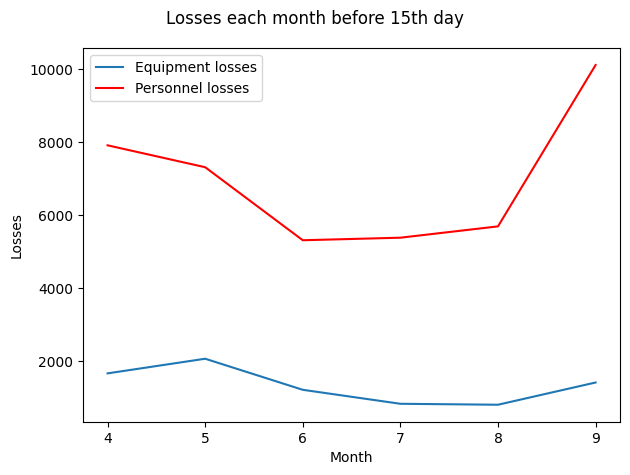

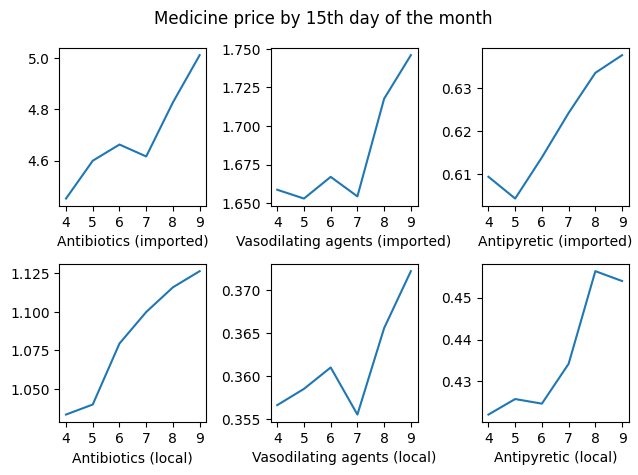

In [141]:
sns.lineplot(df_monthly_equipment)
sns.lineplot(df_monthly_personnel, palette=['r'])
plt.ylabel(ylabel="Losses")
plt.xlabel(xlabel="Month")
plt.suptitle('Losses each month before 15th day')
plt.tight_layout()
plt.show()

df_prices.drop(columns='longitude', inplace=True)

commodities = ['Antibiotics (imported)', 'Vasodilating agents (imported)', 'Antipyretic (imported)', 'Antibiotics (local)',  'Vasodilating agents (local)', 'Antipyretic (local)']
count = 0
for element in commodities:
    df_prices_monthly_single_med = apply_where_groupby_mean_drop(df_prices, 'commodity', 'date', element, index_drops=['2022-03-15'], median=True)
    df_prices_monthly_single_med.index = ['4', '5', '6', '7', '8', '9']
    count +=1
    plt.subplot(2, 3, count)
    sns.lineplot(df_prices_monthly_single_med)
    plt.legend('',frameon=False)
    plt.xlabel(xlabel=element)
plt.suptitle('Medicine price by 15th day of the month')
plt.tight_layout()
plt.show()


- Como veo que en el mes 6 se producen cambios importantes en todas las gráficas, calculo la correlación total, así como la de antes y a partir de ese punto
- Antes de hacerlo, sin embargo, tengo que elegir entre las bajas de personal y las materiales. Ambas siguen una tendencia similar, pero la de personal parece más pronunciada. Creo que puede dar resultados más claros en caso de hacer una correlación. Lo compruebo con el coeficiente de asimetría de Fisher

In [155]:
print(df_monthly_equipment.skew(), '\n', df_monthly_personnel.skew())


Equipment losses    0.401188
dtype: float64 
 Personnel losses    0.989514
dtype: float64


- El coeficiente de asimetría de las bajas de personal está mucho más cerca de 1 porque, si bien en ambos casos hay una asimetría por la derecha (se "hunden" por la derecha), en su caso el desequilibrio es mayor. Ello confirma la corazonada que he tenido al ver la gráfica. Así pues, decido usar las bajas de personal para el cálculo de la correlación
- Creo una lista de listas con los índices que tengo que eliminar para calcular las 3 diferentes correlaciones (recordemos: total, antes del mes 6 y después del mes 6)
- Con la misma función de antes, creo subconjuntos con cada medicamento y la mediana de los precios de las ciudades para cada fecha, pero, esta vez, voy liquidando los índices que no me interesan para cada caso mediante el argumento index_drops
- Cada subconjunto lo fusiono con el dataframe de personal que he creado antes con la función date_index_to_monthly. Es lo mismo que el df_monthly_personnel que he usado para el lineplot de bajas, pero con fechas en el índice (es necesario que sea así para la fusión)
- Meto en una lista cada vector con los números correspondientes a los meses que me interesan, y, luego, todas las listas en una lista más grande
- Con esa lista de listas ya puedo crear el gráfico de correlación

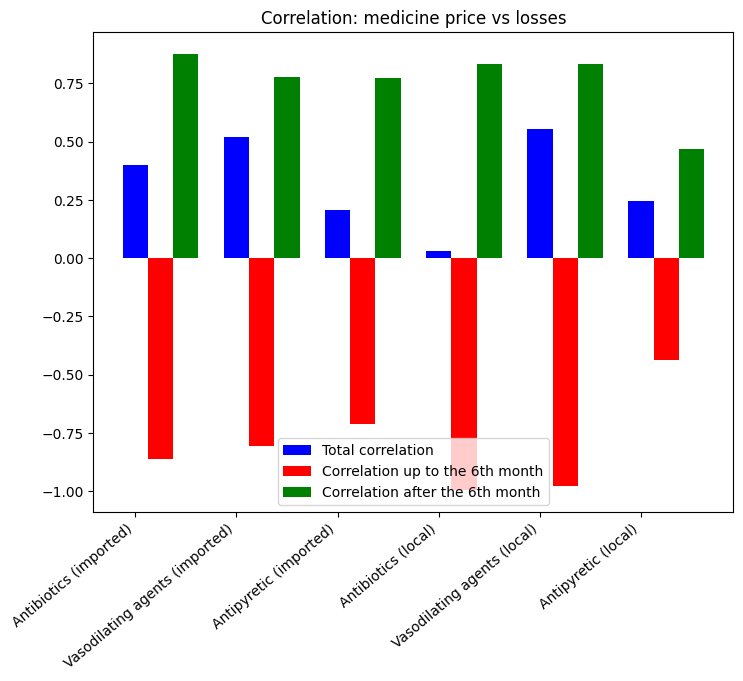

In [143]:
total_index_drops = [['2022-03-15'], ['2022-03-15', '2022-07-15', '2022-08-15', '2022-09-15'], ['2022-03-15', '2022-04-15', '2022-05-15', '2022-06-15']]

corr_vectors = []
for index_drops in total_index_drops:
       corr_vector = []
       for element in commodities:
              df_prices_monthly_single_med = apply_where_groupby_mean_drop(df_prices, 'commodity', 'date', element, index_drops=index_drops, median=True)
              df_price_personnel = df_prices_monthly_single_med.merge(df_monthly_personnel_datetime, left_index=True, right_index=True)
              corr_vector.append(df_price_personnel.corr()['usdprice'][1])
       corr_vectors.append(corr_vector)

X = np.arange(6)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, corr_vectors[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, corr_vectors[1], color = 'r', width = 0.25)
ax.bar(X + 0.50, corr_vectors[2], color = 'g', width = 0.25)
plt.xticks([0, 1, 2, 3, 4, 5], commodities)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.legend(labels=['Total correlation', 'Correlation up to the 6th month', 'Correlation after the 6th month'])
plt.title('Correlation: medicine price vs losses')
plt.show()


Veo que la correlación cambia totalmente de sentido en ambos casos (antes o después del mes 6), y lo hace de manera contundente (para los 6 medicamentos). Podemos concluir, pues:
- En términos generales, las bajas y los medicamentos están inversamente correlacionados, aunque de un modo poco tajante
- Antes del mes 6, van en la dirección contraria
- Sin embargo, a partir del mes 6, van en la misma, y se vuelve muy palpable
- En conclusión, no parece que una afecte a la otra (los medicamentos suben siempre, y las bajas primero bajan y luego suben)
- La hipótesis 2 estudia las bajas personales comparadas con las de equipamiento. Será interesante ver qué ocurre el mes 6 para que se produzca tal cambio

#### Hipótesis 1: parte C

(Más refugiados = precios más bajos)

- Solo queda comprobar si los refugiados siguen una tendencia similar a lo que ya hemos visto; es decir, si pasa algo con ellos en el mes 6
- Echo un vistazo a la tabla

In [144]:
df_refugees['country'].value_counts()


Hungary                     106
Slovakia                    105
Poland                      102
Republic of Moldova         102
Romania                      93
Belarus                      76
Russian Federation           70
Other European countries     11
Name: country, dtype: int64

- La situación es complicada. Quiero saber los refugiados que hay totales los días 15 de cada mes (los del índice de la tabla mensual de precios, pero sin contar el último, ya que la tabla de refugiados acaba el 2022-09-13). Sin embargo, puedo intuir que habrá países para los que no se harán las cuentas todos los meses, y mucho menos el día 15.
- Necesito una función que, por cada día 15 de esos, me mire para qué países hay datos y los sume. Si no encuentra datos para algún país, que mire en la fecha más cercana (el día 16, si acaso existe en el dataframe) para obtener una aproximación. Si sigue sin encontrar nada, que mire en la fecha siguiente... y así sucesivamente hasta haber sumado los datos de todos los países para (más o menos) ese día 15. Luego, la función debe hacer lo mismo para el resto de días 15 de cada mes. Al final, debe devolver un dataframe con el total de refugiados por fecha
- Soy consciente de que lo que obtenga será una aproximación, dado que no todos los valores sumados saldrán realmente del 15 de cada mes. Sin embargo, como la fuente es un acumulado con valores bastante grandes, si procuro que no se alejen demasiado de la fecha que les corresponde (no más de 15 días), creo que obtendré un resultado razonable para detectar una tendencia general
- Tengo la función, se llama sum_by_duplicated_values_and_datetime. Con cada uso, la función imprime el proceso que va haciendo. Con este método, puedo ir calibrando si, para algún país, se aleja demasiado del día 15 a la hora de hacer su aproximación, y valorar si tengo que eliminarlo de la tabla
- Tras varios usos, estos son los países que me veo obligado a desechar: solo uno, "Other European countries", que ya se aleja lo indecible de la primera fecha 15 en la primera vuelta, pues no es capaz de rellenar ni un mes (todos sus valores deben ser anteriores al 2022-03-15). Ninguno más, ya que los datos para el resto de países se encuentran antes de llegar al 30 del propio mes, con lo que considero que son una aproximación válida.

In [145]:
condition = df_refugees[(df_refugees['country'] == 'Other European countries')].index
df_refugees.drop(condition, inplace=True)

df_monthly_refugees = sum_by_duplicated_values_and_datetime(df_refugees, 'country', 'individuals', datetimes_to_study[:-1])


Now checking for 2022-03-15 00:00:00
2022-03-15 00:00:00 has been filled


Now checking for 2022-04-15 00:00:00
Missing: ['Russian Federation', 'Belarus']
Add 1 day/s. Current date: 2022-04-16 00:00:00
Missing: ['Russian Federation', 'Belarus']
Add 1 day/s. Current date: 2022-04-17 00:00:00
Missing: ['Russian Federation', 'Belarus']
Russian Federation found at 2022-04-17 00:00:00
Belarus found at 2022-04-17 00:00:00
2022-04-15 00:00:00 has been filled


Now checking for 2022-05-15 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-16 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-17 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-18 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-19 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-20 00:00:00
Missing: ['Belarus']
Add 1 day/s. Current date: 2022-05-21 00:00:00
2022-05-21 00:00:00 does not exist in the dataframe
Add 1 day/s. Current date: 2022-05-22 00:00:0

- Desacumulo df_refugees (decumulate_columns), me llevo la fecha al índice (index_by_datetime), borro el primer mes (ya que no hay con qué desacumularlo), modifico el índice para mostrar solo los meses y tengo la tabla resultante

In [146]:
decumulate_columns(df_monthly_refugees, excluded='date')
index_by_datetime(df_monthly_refugees, name='date')

df_monthly_refugees.drop(index='2022-03-15', inplace=True) 
df_monthly_refugees.index = ['4', '5', '6' , '7', '8']

df_monthly_refugees


,Total
4,1811671
5,1338294
6,1490797
7,1844112
8,1652311


- A partir de ahí hago la gráfica. Detecto que, efectivamente, entre el mes 6 y el 7 los refugiados se disparan

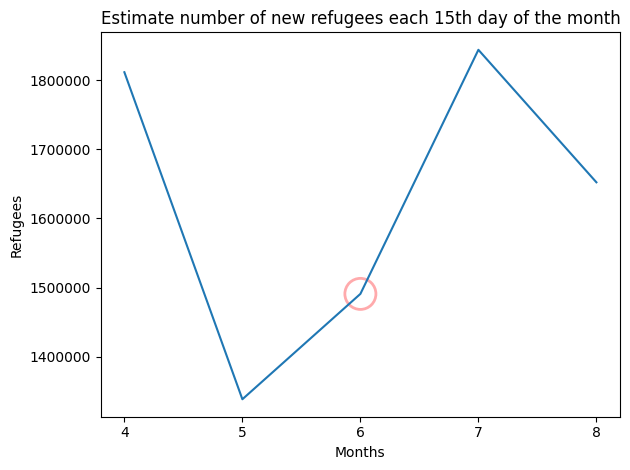

In [147]:
fig, ax = plt.subplots()
ax.scatter(2, 1490797, s=500, edgecolor='#ff575a', lw=2, facecolor='none', alpha=0.5, zorder=1)
sns.lineplot(y=df_monthly_refugees['Total'], x=df_monthly_refugees.index)
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel(ylabel='Refugees')
plt.xlabel(xlabel='Months')
plt.title('Estimate number of new refugees each 15th day of the month')
plt.tight_layout()
plt.show()


#### Hipótesis 1: conclusiones

Parte A
- No hay relación palpable entre la cercanía al frente y el precio de la medicina. La guerra moderna, con artillería de larga distancia y bombardeos aéreos, y con un frente largo y difícil de calcular, implica que todas las ciudades sean susceptibles de sufrir problemas puntuales de suministramiento independientemente de su proximidad al enemigo
- El precio de la medicina local varía más que el de la importada en términos generales. Como es más barata, y tratándose de una situación de guerra, probablemente se produzcan frecuentes desequilibros entre oferta y demanda -que es la principal causa de las oscilaciones en los precios de un mercado-
- El precio de la medicina de importación es más estable, excepto en el caso de los antibióticos. Dado que son más caros que los locales, tratándose de un producto de consumo (y no premium o de lujo), se deduce que gente recurre a ellos cuando no quedan medicamentos locales, con lo que se producen menos desequilibros entre oferta y demanda que alteren el precio. Por esa razón, las oscilaciones en el precio de los antibióticos importados podrían indicar -siendo estos, por añadidura, un tanto más caros-, una escasez de antibióticos.
- A pesar de ello, es poco probable que las diferencias en el precio de los medicamentos, por sí solas, supongan un problema para los consumidores, ya que el índice de Gini es bajo para todos; el único problema es que escaseen


Parte B
- No hay una relación palpable entre el precio de la medicina y las pérdidas rusas. En términos generales, el precio de la medicina sube, mientras que las pérdidas primero bajan y luego suben
- Es a partir del mes 6 que las bajas rusas vuelven a subir

Parte C
- Los refugiados mensuales se disparan entre el mes 6 y el 7, momento en que hemos visto que las bajas rusas llegan a su punto más bajo (es probable que la guerra se recrudezca en este punto)
- He desmentido de forma prematura la hipótesis 2 con el lineplot de bajas (las bajas personales y materiales rusas no siguen tendencias diametralmente opuestas). Sin embargo, haré la investigación correspondiente para encontrar pistas sobre lo que pasa alrededor del mes 6

### Hipótesis 2

(Uso mayor de tropas mecanizadas = uso reducido de soldados rasos = más pérdidas materiales y menos muertos)

- Aunque ya sé que la hipótesis no se cumple, investigar el dataset de equipamiento quizá me ayude a arrojar luz sobre lo que ocurre con el mes 6
- Empiezo con un boxplot, con el que veo que 1) hay diferencias importantes en los números de bajas; 2) los outliers de las bajas totales ("total losses"), con toda probabilidad, vienen de las bajas de APC - que, además, son mayoritarias- pues se despliegan de un modo similar a partir del quartil 3 + 1.5 veces el rango intercuartílico; 3) No hay outliers en el límite inferior de las bajas totales ni de APC, lo que significa que no deberé preocuparme por números exajeradamente bajos si, por alguna razón, acabo mirando por debajo de la mediana

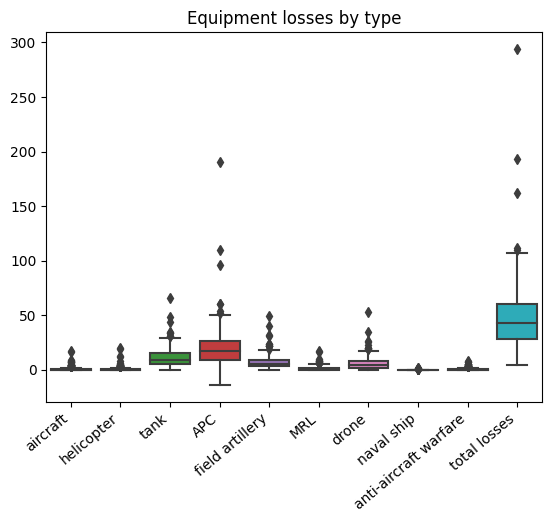

In [148]:
ax = sns.boxplot(df_equipment)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title('Equipment losses by type')
plt.show()


- Quiero ver cómo se comportan las bajas de cada tipo en relación al total, día a día, para detectar tendencias. También quiero ver si hay algun outlier en el que deba fijarme en particular, uno que corresponda a algún momento clave de la guerra
- Para ello utilizo un scatterplot que, si bien no es del todo limpio por la cantidad ingente de puntos que contiene, sí que se perciben dos picos (antes y después del mes 6) que parecen surgir de las bajas por APC
- Percibo, también, un error relativo a las bajas de APC entre 2022-10 y 2022-11, y es que no puede haber bajas negativas

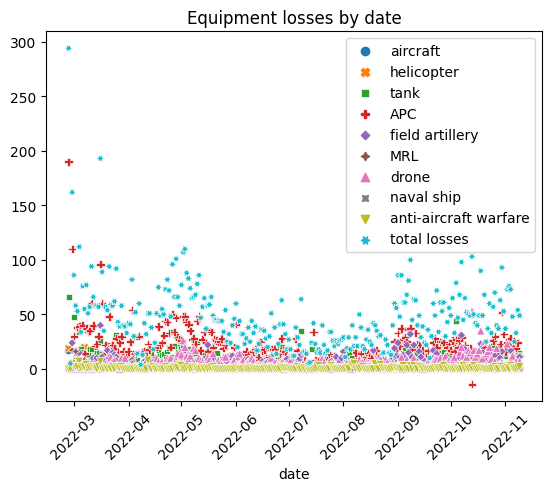

In [149]:
ax = sns.scatterplot(df_equipment)
ax.tick_params(axis='x', labelrotation = 45)
plt.title('Equipment losses by date')
plt.show()


- Una vez localizado el error, pregunto al creador del dataset y parece que es una corrección de los datos acumulados: https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war/discussion/369515
- Decido ignorarlo porque es algo muy pequeño y puntual como para afectar a la visión conjunta

In [150]:
df_equipment[df_equipment.index == '2022-10-13']


,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,total losses
date,,,,,,,,,,
2022-10-13,0,5,6,-14,49,2,53,1,1,103


- Con lo visto, intuyo que son las bajas de APC las que determinan la tendencia general de las bajas totales, las que tienen "más peso". Por tanto, deduzco de que son las responsables de la caída de bajas diarias totales que empieza en el mes 6. Para cerciorarme, antes de pasar a hacer las comprobaciones matemáticas, me sirvo de dos gráficos: uno con las bajas de APC y las pérdidas totales, y otro con el resto de tipos de bajas y las pérdidas totales.
- Noto que, efectivamente, en el gráfico con las bajas de APC el rojo y el azul se parecen más que en la otra (sobre todo para el período que me interesa; esto es, desde el mes 6 hasta el 9, que es cuando las bajas totales vuelven a subir)

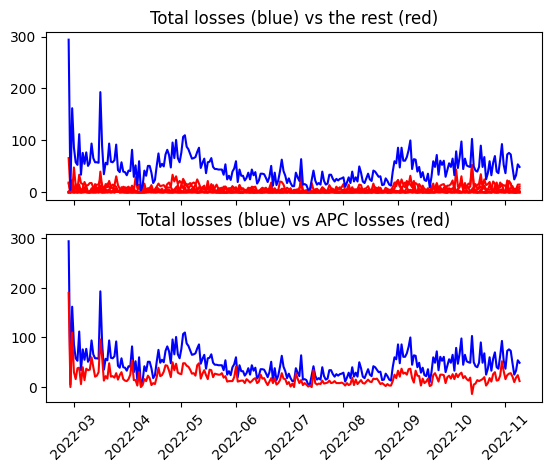

In [151]:
fig, ax = plt.subplots(2)
ax[0].plot(df_equipment.index, df_equipment.drop(columns=['APC', 'total losses']), 'r', df_equipment.index, df_equipment['total losses'], 'b')
ax[0].tick_params(labelbottom=False)
ax[0].title.set_text('Total losses (blue) vs the rest (red)')
ax[1].plot(df_equipment.index, df_equipment['total losses'], 'b', df_equipment.index, df_equipment['APC'], 'r')
ax[1].tick_params(axis='x', labelrotation = 45)
ax[1].title.set_text('Total losses (blue) vs APC losses (red)')
plt.show()


- Para acabar de probar la relación APC-bajas totales, quiero ver si es cierto que las bajas de APC son una mayoría clara con respecto a todas las demás

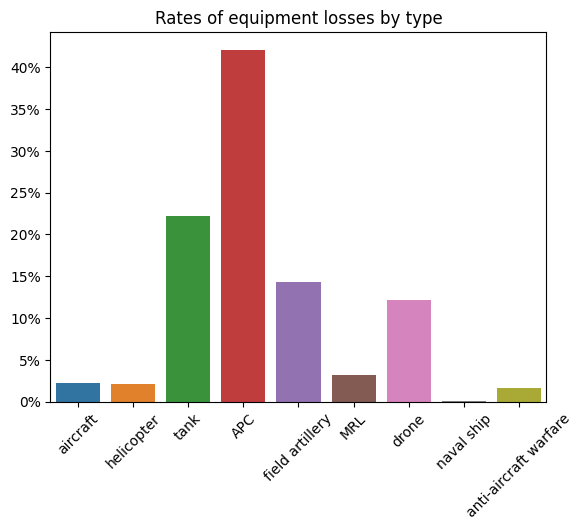

In [152]:
column_names = []
results = []
for column in df_equipment:
    if column != 'total losses':
        column_names.append(column)
        results.append(sum(df_equipment[column]) /  sum(df_equipment['total losses']) * 100)

sns.barplot(x=column_names, y=results)
plt.tick_params(axis='x', labelrotation = 45)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40], ['0%', '5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%'])
plt.title('Rates of equipment losses by type')
plt.show()


- Quiero demostrar, ahora, la caída entre el mes 6 y el 9, que se intuye por los gráficos pero no se percibe con total claridad
- Necesito la probabilidad de que un conjunto de bajas diarias situado entre el mes 6 (incluido, que es el estándar al calcular intervalos) y el 9 esté por debajo de la mediana
- ¿Por qué la mediana? Por dos razones: 1) He visto que hay outliers, de ahí que prefiera la mediana antes que la media, y 2) no hay outliers por debajo de la mediana, como demuestra el boxplot previo
- Según la fórmula de la probabilidad condicionada, tengo que dividir la probabilidad de que un conjunto de bajas diarias al azar esté entre el mes 6 y el 9 y por debajo de la mediana (interseccion), entre el porcentaje de fechas que se cuentan en este intervalo
- El 90% de las bajas diarias que se encuentran en este período están por debajo de la mediana. Esto demuestra matemáticamente que hay una bajada entre los meses 6 y 9

In [153]:
p_interseccion_mediana_periodo = (len(df_equipment[(df_equipment['total losses'] < df_equipment['total losses'].median())
                                    & (df_equipment.index >= '2022-06-01') 
                                    & (df_equipment.index < '2022-09-01')]
                                        ) / len(df_equipment['total losses'])
                                    )

p_periodo = len(df_equipment[(df_equipment.index >= '2022-06-01') & (df_equipment.index < '2022-09-01')]) / len(df_equipment.index)

p_periodo_mediana = p_interseccion_mediana_periodo / p_periodo * 100

p_periodo_mediana


90.21739130434783

#### Hipótesis 2: conclusiones

- La mayoría de bajas son de APC. Esas son las siglas de Armored Personnel Carrier, lo cual implica que hay bajas de personal simultáneamente, ya que se destruyen vehículos dedicados al transporte de personal
- La mayor parte de bajas diarias para el período de 6 a 9 meses están por debajo de la mediana
- Como hemos visto en el primer gráfico de "Hipótesis 1: parte B", las bajas de personal para ese período (aproximadamente) también se encuentran en su punto más bajo
- Se deduce, pues, que el hecho de que haya menos bajas de personal se debe a que se han destruido menos APC rusos que transporten tropas
- Cabe recordar que, en este punto, también suben mucho los refugiados. Para este período, es probable que Rusia se esté apoyando más en bombardeos y artillería que en la conquista de territorio con tropas terrestres. Eso explicaría tanto el aumento de refugiados como la menor pérdida de convoyes de APC -y, por ende, de personal en general-. Quizá sea arriesgado permanecer en una ciudad ocupada... pero es imposible hacerlo en una metrópoli devastada por las bombas

### Hipótesis 3

(Uso de material soviético = más destrucciones y más capturas)